In [298]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

import astropy
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
#plt.style.use('../../cooper-presentation.mplstyle')

In [299]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/cosmos/'  
#dir_out = './'  # the directory where the output of this notebook will be stored
fitversion = 'lp'  
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [300]:
# Upload the main catalogue
cat0 = Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

In [306]:
notes = Table.read('cooper_full_notes.csv',format='csv')
c2020_sample = notes[notes['photoz_source'] == 'c2020']
c2020_sample

<Table length=83>
 mask  slit_no            obj             c2020_id ypix_mospy ... spat_fracpos box_width opt_fwhm   s2n   maskdef_extract
 str6   int64            str26             int64     int64    ...   float64      int64   float64  float64       str5     
------ ------- -------------------------- -------- ---------- ... ------------ --------- -------- ------- ---------------
wmmc01       1                 M_WP551495   551495       2219 ...        0.481         1      0.3    0.03            True
wmmc01       2                 B_WP450980   450980       2166 ...        0.552         1      0.3    0.04            True
wmmc01       4                 L_WP693466   693466       2050 ...        0.612         1      0.3    0.26            True
wmmc01       5 c2020_pz_0.664_22.8_826089   826089       1970 ...        0.464         1      0.3    0.85            True
wmmc01       6                 L_WP930991   930991         -- ...        0.536         1      0.3   -0.01            True
wmmc01       7  c2020_pz_1.65_22.6_640174   640174       1869 ...        0.556         1      0.3    0.61            True
wmmc01       8  c2020_pz_4.25_27.1_702146   702146         -- ...         0.56         1      0.3    0.02            True
wmmc01       9 c2020_pz_0.486_24.7_889105   889105       1724 ...        0.571         1      0.3    0.13            True
wmmc01      10  c2020_pz_4.82_26.4_510074   510074         -- ...         0.52         1      0.3    0.04            True
wmmc01      12  c2020_pz_4.11_25.3_592463   592463         -- ...          0.5         1      0.3    0.07            True
wmmc01      13                 L_WP737150   737150         -- ...         0.66         1      0.3   -0.14            True
wmmc01      15  c2020_pz_1.95_23.1_891793   891793       1292 ...        0.536         1      0.3    0.41            True
wmmc01      16  c2020_pz_4.33_0.00_829943   829943         -- ...          0.7         1      0.3   -0.02            True
wmmc01      17                 B_WP547670   547670       1119 ...         0.44         1      0.3   -0.14            True
wmmc01      19                 B_WP493215   493215        955 ...         0.36         1      0.3     0.0            True
wmmc01      21                 B_WP567863   567863        770 ...         0.44         1      0.3    0.33            True
wmmc01      23  c2020_pz_4.46_26.2_766559   766559         -- ...        0.556         1      0.3     0.2            True
wmmc01      24 c2020_pz_0.559_24.4_810968   810968        562 ...        0.536         1      0.3    0.01            True
wmmc01      25                 B_WP143124   143124        494 ...         0.58         1      0.3    0.02            True
wmmc01      26  c2020_pz_1.73_24.6_725414   725414        418 ...        0.481         1      0.3    0.05            True
wmmc01      27                CAND_B10404    10404         -- ...         0.42         1      0.3    0.26            True
wmmc01      32  c2020_pz_4.67_28.8_164311   164311         -- ...        0.393         1      0.3     0.0            True
   ...     ...                        ...      ...        ... ...          ...       ...      ...     ...             ...
wmmc05      28                 M_WP956582   956582         -- ...        0.481         1      0.5    0.04            TRUE
wmmc05      29  c2020_pz_4.45_25.8_938343   938343        309 ...        0.536         1      0.5   -2.88            TRUE
wmmc05      32                 L_WP899972   899972         -- ...        0.408         1      0.5    0.13            TRUE
wmmc05      33                 B_WP786362   786362         27 ...        0.481         1      0.5     0.3            TRUE
wmmc06       2  c2020_pz_4.73_25.6_754927   754927         -- ...        0.519         1     0.35    0.05            TRUE
wmmc06       3  c2020_pz_4.47_26.0_744202   744202         -- ...        0.571         1     0.35   -0.06            TRUE
wmmc06       4                  rb_20_919   678784         -- ...          0.5

In [307]:
c2020_sample['c2020_id'].name = 'ID'
cat0cut = astropy.table.join(c2020_sample, cat0, keys='ID')

In [308]:
cat0cut.write('WERLSv1_COSMOS2020_FARMER_R1_v2.0.fits',format='fits',overwrite=True)

In [309]:
cat1 = Table.read('WERLSv1_COSMOS2020_FARMER_R1_v2.0.fits',format='fits',hdu=1)
cat1

<Table length=83>
 mask  slit_no            obj               ID   ...      ez_Av_p500           ez_Av_p840           ez_Av_p975     
                                                 ...         mag                  mag                  mag         
bytes6  int64           bytes26           int64  ...       float64              float64              float64       
------ ------- -------------------------- ------ ... -------------------- -------------------- --------------------
wmmc01      27                CAND_B10404  10404 ...                   --                   --                   --
wmmc05      24   c2020_pz_4.29_0.00_20954  20954 ...                   --                   --                   --
wmmc06      26                  B_WP23111  23111 ...  0.12561350051491224  0.18995227237824333   0.2345275600844766
wmmc06      30                CAND_L58875  58875 ...                   --                   --                   --
wmmc05      22   c2020_pz_4.34_26.2_72989  72989 ...    0.805845743347418   0.8839397296568455   0.9385010688331223
wmmc05      26   c2020_pz_1.84_24.6_86638  86638 ...  0.03846124223190879  0.03846124223190879  0.03846124223190902
wmmc06      21  c2020_pz_0.630_23.8_86724  86724 ...  0.32879558679805926   0.3576971041706971  0.38858318742691017
wmmc05      23  c2020_pz_4.11_25.8_102408 102408 ...   0.5989736742405174   0.9210587603603146   1.2104850152167645
wmmc05      25 c2020_pz_0.532_21.3_106340 106340 ...  0.41797586000081866   0.5241072921490195   0.5987167695069954
wmmc01      25                 B_WP143124 143124 ...  0.42580263589780365   0.4348683742290587   0.4355275356643554
wmmc02      27                 B_WP143124 143124 ...  0.42580263589780365   0.4348683742290587   0.4355275356643554
wmmc05      21  c2020_pz_4.26_26.2_151499 151499 ...   0.5831227497907101   0.8032571180706952    0.933664394784029
wmmc02      25  c2020_pz_1.75_26.8_161501 161501 ...   0.7308575154828569   0.8045274549094646   0.8981927558233714
wmmc01      32  c2020_pz_4.67_28.8_164311 164311 ...                   --                   --                   --
wmmc02      24  c2020_pz_4.67_28.8_164311 164311 ...                   --                   --                   --
wmmc06      22               rb_15_417416 196040 ...   0.7049458418774319   0.8177728670129277    0.849019044126484
wmmc05      20  c2020_pz_1.18_26.4_235292 235292 ...  0.02687327796133844  0.02687327796133844 0.026873277961338673
wmmc02      22  c2020_pz_1.86_25.0_248934 248934 ...   0.2994131046259378   0.4219245382709331   0.5057775080899403
wmmc06      20                 L_WP276587 276587 ... 0.017421044505293668 0.017421044505293668 0.017421044505293668
wmmc02      21  c2020_pz_1.25_21.2_283320 283320 ...   0.9744192538243703   1.0512993244429636   1.1466746527568226
wmmc02      19  c2020_pz_4.51_27.0_319593 319593 ...  0.27665568943622476   0.3658579209161274    0.426663515990805
wmmc05      16  c2020_pz_4.18_25.7_345492 345492 ...   0.7612667650360558   0.8468317418151046   0.9197774316470412
   ...     ...                        ...    ... ...                  ...                  ...                  ...
wmmc06       3  c2020_pz_4.47_26.0_744202 744202 ...   1.6183959862432693     1.66668433022198   1.7324553832074865
wmmc06       2  c2020_pz_4.73_25.6_754927 754927 ...   0.7402926396063838    0.807995483780252   0.8726552134059323
wmmc01      23  c2020_pz_4.46_26.2_766559 766559 ...                   --                   --                   --
wmmc05      33                 B_WP786362 786362 ...   0.4270967872307471  0.43815513224858665   0.4464733834083199
wmmc02      32  c2020_pz_1.24_26.1_797274 797274 ...  0.03267757040844596  0.03267757040844596  0.03267757040844596
wmmc01      24 c2020_pz_0.559_24.4_810968 810968 ... 0.018736612631158167 0.018736612631158167 0.018736612631158167
wmmc01       5 c2020_pz_0.664_22.8_826089 826089 ...   0.5091701877309209   0.6228744567271713   0.6655723139356668
wmmc01      16  c2020_pz_4.33_0.00_829

In [56]:
print(targ['lp_zBEST'])
print('')
print(targ['lp_MFUV'])

lp_zBEST
--------
   4.753

 lp_MFUV 
   mag   
---------
-19.03714


In [57]:
MUV = targ['UVISTA_J_MAG']-cosmo.distmod(zguess)+(2.5*np.log10(1+zguess))

print("check phot MUV: ",targ['UVISTA_J_MAG']-cosmo.distmod(targ['lp_zBEST'])+(2.5*np.log10(1+targ['lp_zBEST'])))
print("")
print("spec MUV: ",MUV)

check phot MUV:      UVISTA_J_MAG   
        mag        
-------------------
-17.198904248146277

spec MUV:  UVISTA_J_MAG
    mag     
------------
         nan


In [88]:
pdfcat = fits.open(dir_in+'COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits')
pdfcat[0].data[cat1[0]['ID']]

array([10404.,     0.,     0., ...,     0.,     0.,     0.], dtype=float32)

In [92]:
pdfcat[0].data

array([[          nan, 0.0000000e+00, 9.9999998e-03, ..., 9.9799995e+00,
        9.9899998e+00, 1.0000000e+01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0000000e+00, 0.0000000e+00, 1.0547605e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [9.6450400e+05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.6450500e+05, 0.0000000e+00, 7.2430000e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.6450600e+05, 0.0000000e+00, 0.0000000e+00, ..., 1.9060000e-03,
        1.9200000e-03, 1.9330001e-03]], dtype=float32)

In [59]:
zpdf = pdfcat[0].data[obj]

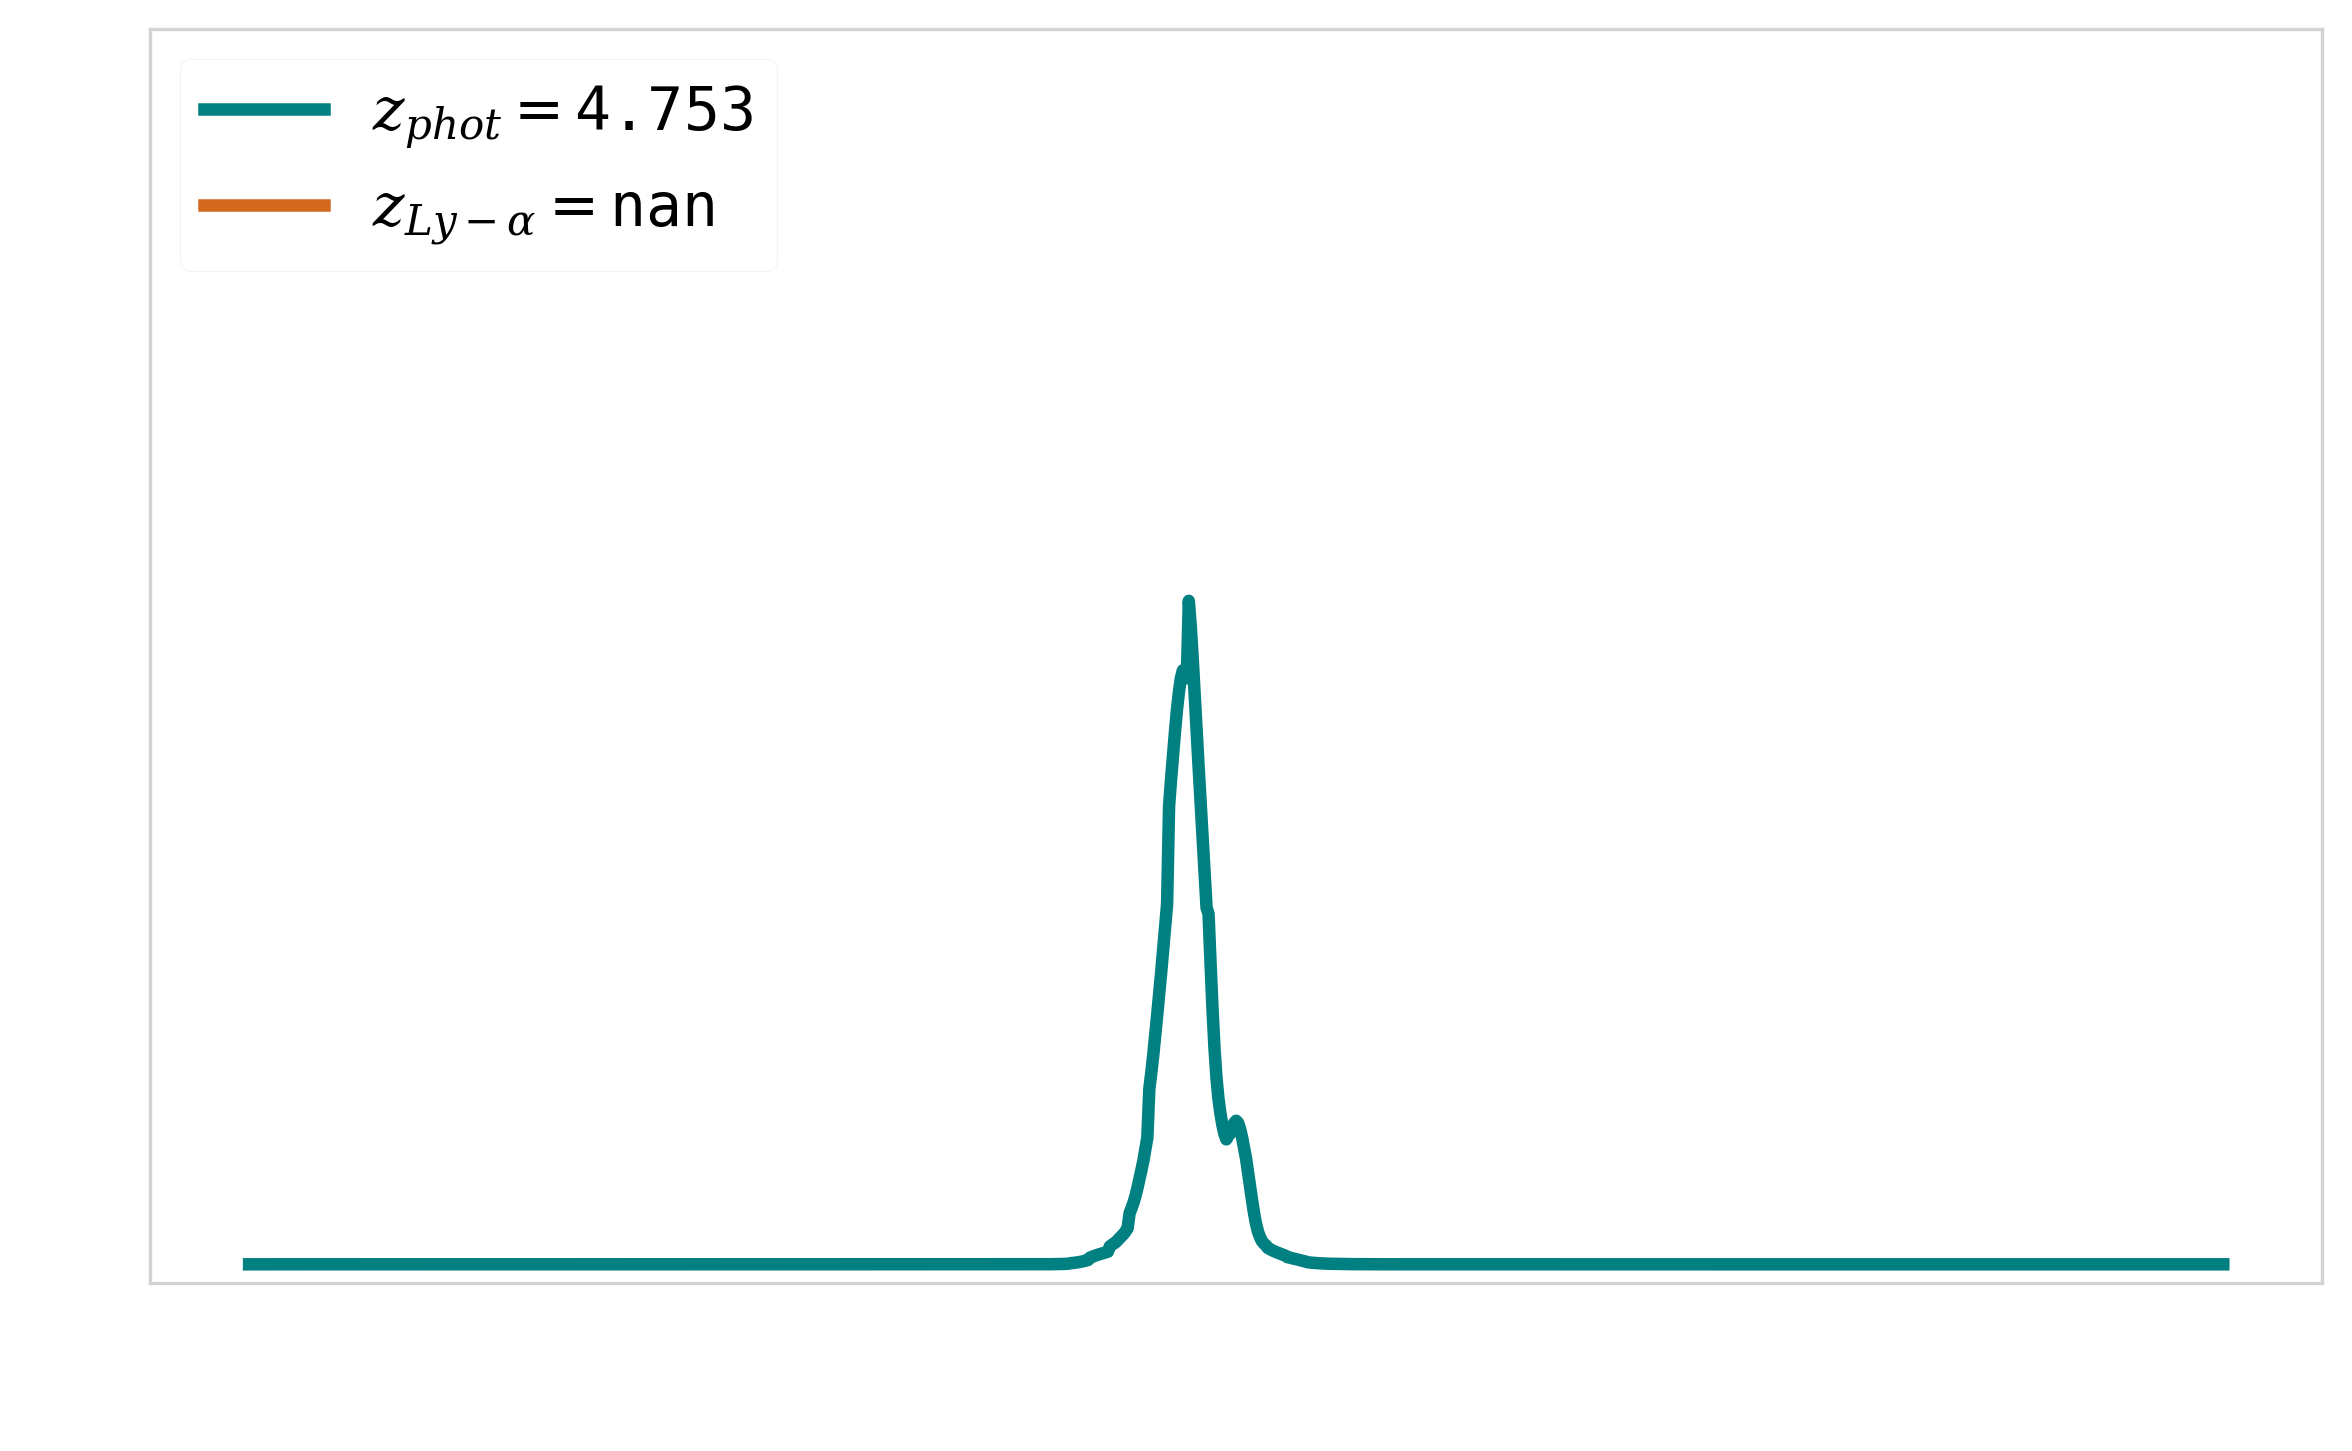

In [60]:
plt.figure(figsize=(8.,5))
zarr = np.linspace(0,10,num=len(zpdf[1:]))
plt.plot(zarr,zpdf[1:],c='teal',lw=3,label=r'$z_{phot}=$'+str(targ['lp_zBEST'][0]))
plt.axvline(zguess,c='chocolate',lw=3,label=r'$z_{Ly-\alpha}=$'+str(zguess))
plt.xlabel('Redshift')
plt.ylabel('LePhare PDF')
#plt.xlim(6.,7.5)
plt.ylim(-0.1,6.7)
plt.legend(fontsize='large',loc='upper left')
plt.grid(False)
plt.show()

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 25 11:39:36 2022

@author: 0cooper
"""

# the basics
import sys
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

import astropy
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
plt.style.use('../cooper-paper.mplstyle')


# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/cosmos/COSMOS2020_R1/'  
#dir_out = './'  # the directory where the output of this notebook will be stored
fitversion = 'lp'  
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}
# read in sed template file
hdf = h5py.File(dir_in+"../cosmos2020-readcat-main/COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

def dust_ext(w,law=0,ebv=0.):
    
    law1 = np.loadtxt("../SB_calzetti.dat").T
    law2 = np.loadtxt("../extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.
    
    
# read in the catalog for only WERLS sources
cat0 = Table.read('WERLSv1_COSMOS2020_FARMER_R1_v2.0.fits',format='fits',hdu=1)

# select object
obj_name = 'M_WP551495'
idx = np.where(cat0['obj']==obj_name)[0]
targ = cat0[idx]
zguess = float(targ['zguess'])
print('working on object',obj_name,'with zguess = ',zguess)

# print best fits params of interest
print(targ['lp_zBEST'])
print('')
print(targ['lp_MFUV'])

# find UV mag
MUV = targ['UVISTA_J_MAG']-cosmo.distmod(zguess)+(2.5*np.log10(1+zguess))

print("check phot MUV: ",targ['UVISTA_J_MAG']-cosmo.distmod(targ['lp_zBEST'])+(2.5*np.log10(1+targ['lp_zBEST'])))
print("")
print("spec MUV: ",MUV)

# optional: change the filters you want to use
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']

# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        targ[b+'_FLUX'] *= 1e-29
        targ[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        targ[b+'_FLUXERR'] *= 1e-29
        targ[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        
# grab just the photometry
photcat = targ[([i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use])]


working on object M_WP551495 with zguess =  7.43
lp_zBEST
--------
  7.4021

 lp_MFUV 
   mag   
---------
-21.41499
check phot MUV:      UVISTA_J_MAG   
        mag        
-------------------
-21.453552177665095

spec MUV:      UVISTA_J_MAG   
        mag        
-------------------
-21.459349463387518


In [46]:
# open zpdf catalog
pdfcat = fits.open(dir_in+'../COSMOS2020_{}_R1_v2.0_LEPHARE_PZ.fits'.format(catversion.upper()))
zpdf = pdfcat[0].data[targ['ID']][0]

The COSMOS fitted model is model number 10
The offset applied is [6937201.37491233] and a redshift of lp_zBEST
--------
  7.4021


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


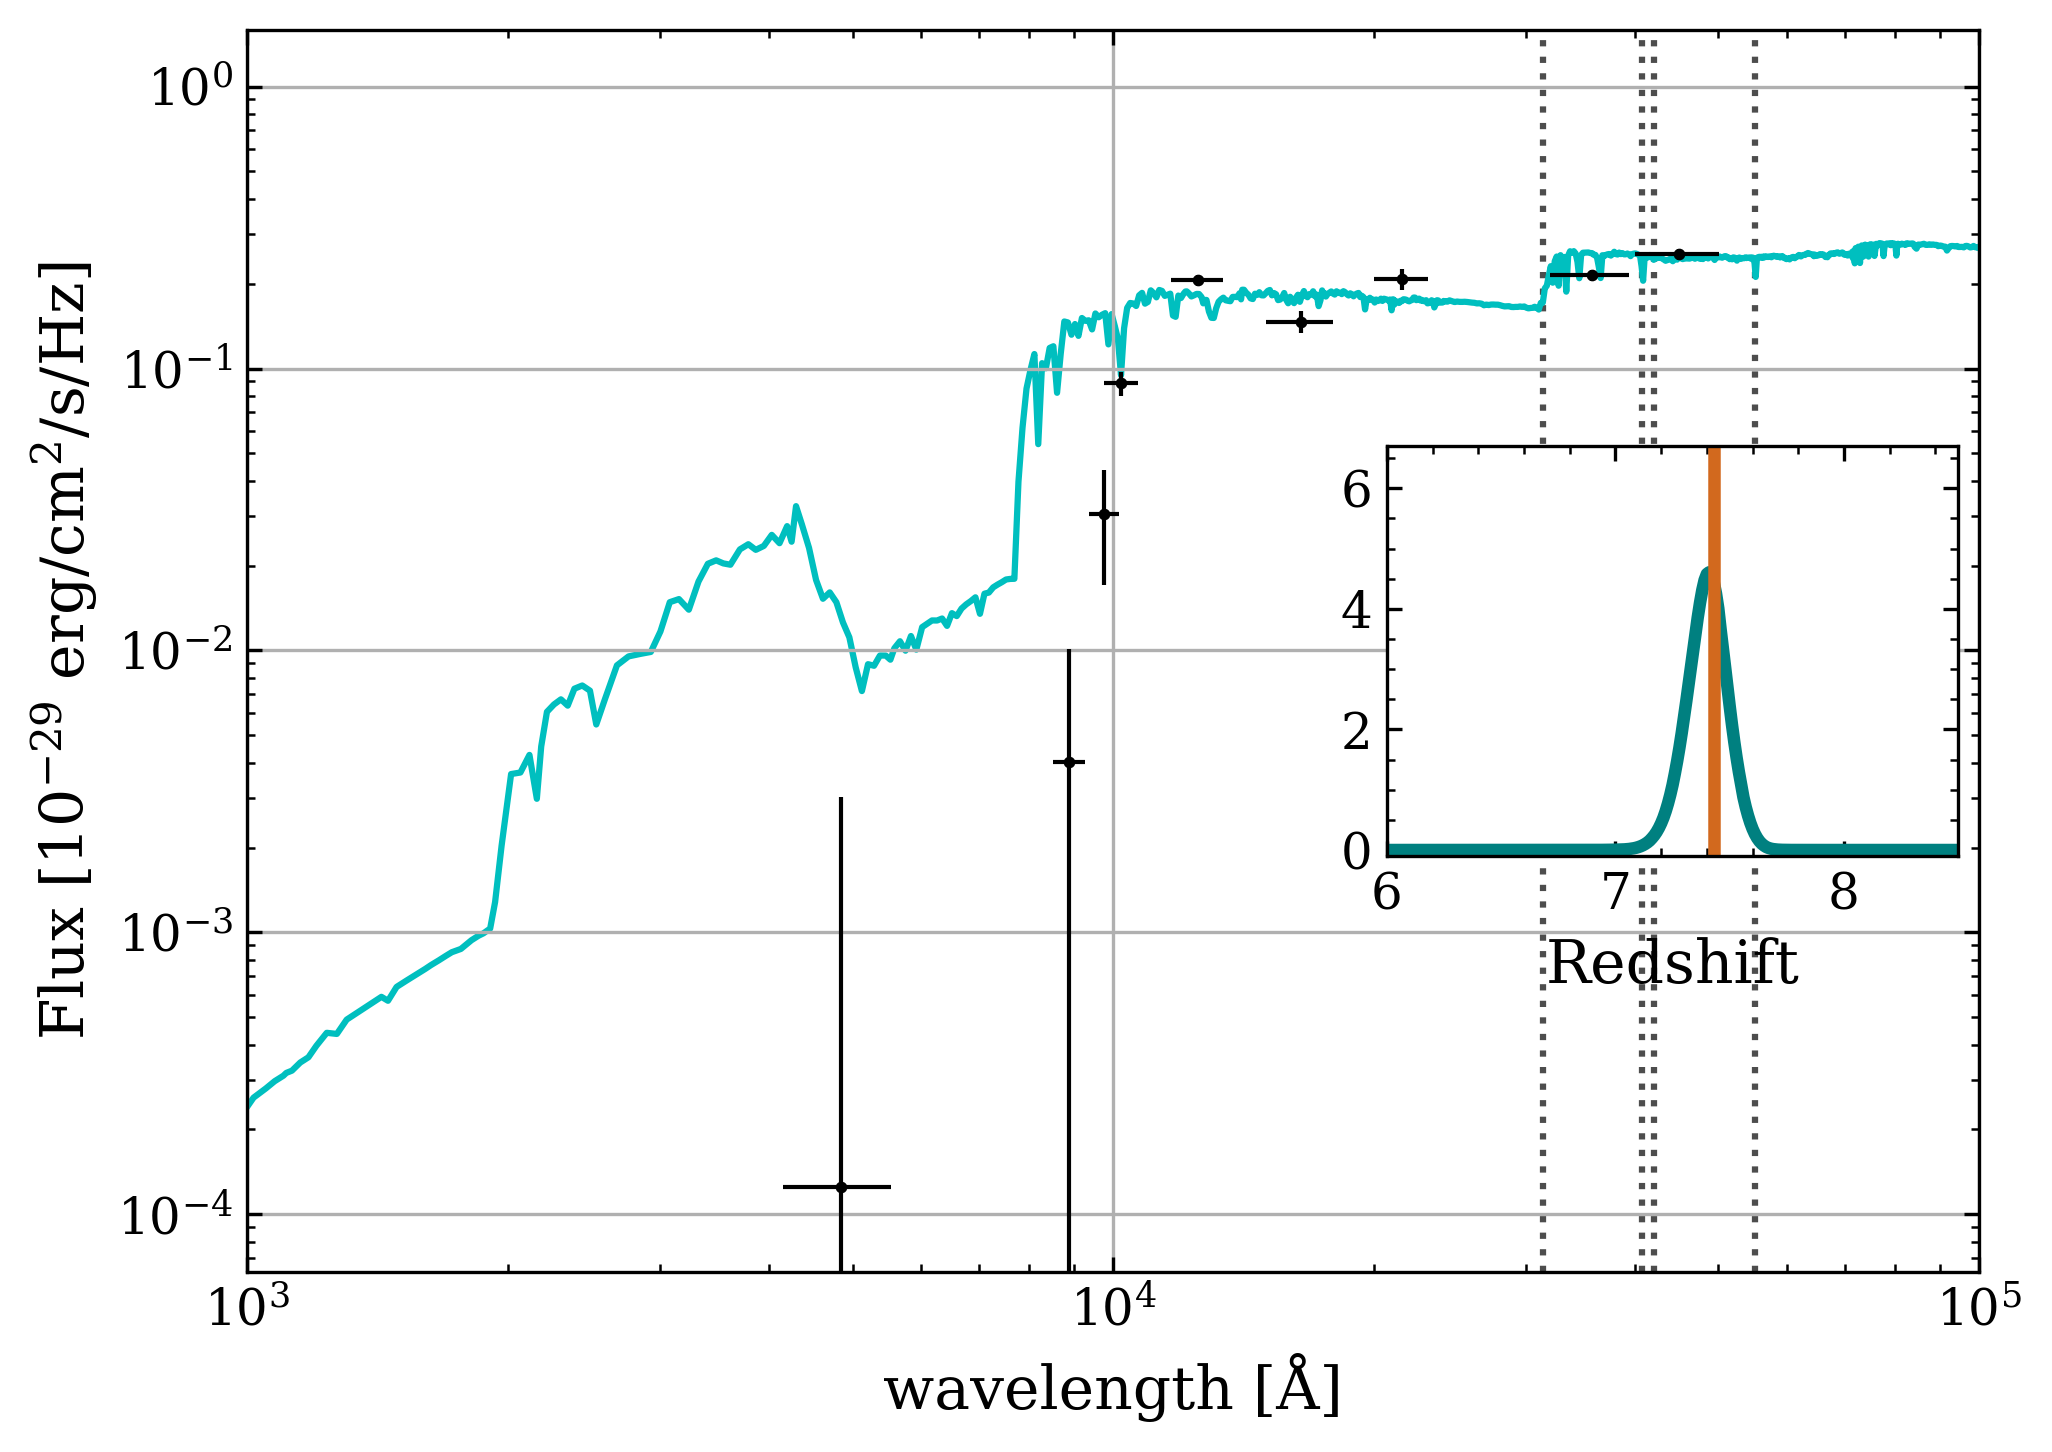

In [66]:
wl_obs = np.array([filt_dict[i][0] for i in filt_use]).flatten()  # wavelength center of the filter used 
wl_obserr = (np.array([filt_dict[i][1] for i in filt_use])/2.).flatten()
fnu_obs = np.array([targ[i+'_FLUX'] for i in filt_use]).flatten() # Reads the measured magnitude at that wavelength
fnu_obserr = np.array([targ[i+'_FLUXERR'] for i in filt_use]).flatten() #Magnitude associated +/-error
sel = (fnu_obs>0.).flatten()


### Begin figure!
fig, ax = plt.subplots(1, figsize=[7,5])


if targ['{}_FLUX'.format(filt_use[0])].unit.to_string()=='uJy':
    ax.set_ylabel('Flux [$\mu$Jy]')
    ax.errorbar(wl_obs[sel],fnu_obs[sel],xerr=wl_obserr[sel],yerr=fnu_obserr[sel],fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*6
else: # assuming it's cgs
    ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
    ax.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*1e29*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6
    
# Using the redshift of best-fit template
zp = targ['lp_zBEST']
m = int(targ['lp_model'])
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA 
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-targ['lp_age']).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA 
fnu_mod = flam_mod*(wvl**2)/const.c 
# Calculates the flux in units of [uJy] also applying dust ext
fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=int(targ['lp_Attenuation']),ebv=targ['lp_dust'])
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**targ['lp_mass_best']  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor


# Plot the best-fit model 
ax.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='c',alpha=1,label='model',zorder=1) 

# Show where nebular emission lines would potentially boost the flux
ax.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
ax.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
ax.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
ax.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha 

# set plot limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1000,100000) 
ax.set_ylim(ymin,ymax)
ax.set_xlabel('wavelength [Å]')

# plot zpdf
# Create inset of width 30% and height 40% of the parent axes' bounding box
axin = inset_axes(ax, width="33%", height="33%", loc='center right')
zarr = np.linspace(0,10,num=len(zpdf[1:]))
axin.plot(zarr,zpdf[1:],c='teal',lw=3,label=r'$z_{phot}=$'+str(targ['lp_zBEST'][0]))
axin.axvline(zguess,c='chocolate',lw=3,label=r'$z_{Ly-\alpha}=$'+str(zguess))
axin.set_xlabel('Redshift')
#axin.set_ylabel('LePhare PDF')
axin.set_xlim(6.,8.5)
axin.set_ylim(-0.1,6.7)
axin.grid(False)

print("The COSMOS fitted model is model number",m)
print('The offset applied is',offset,'and a redshift of',zp)
plt.show()  

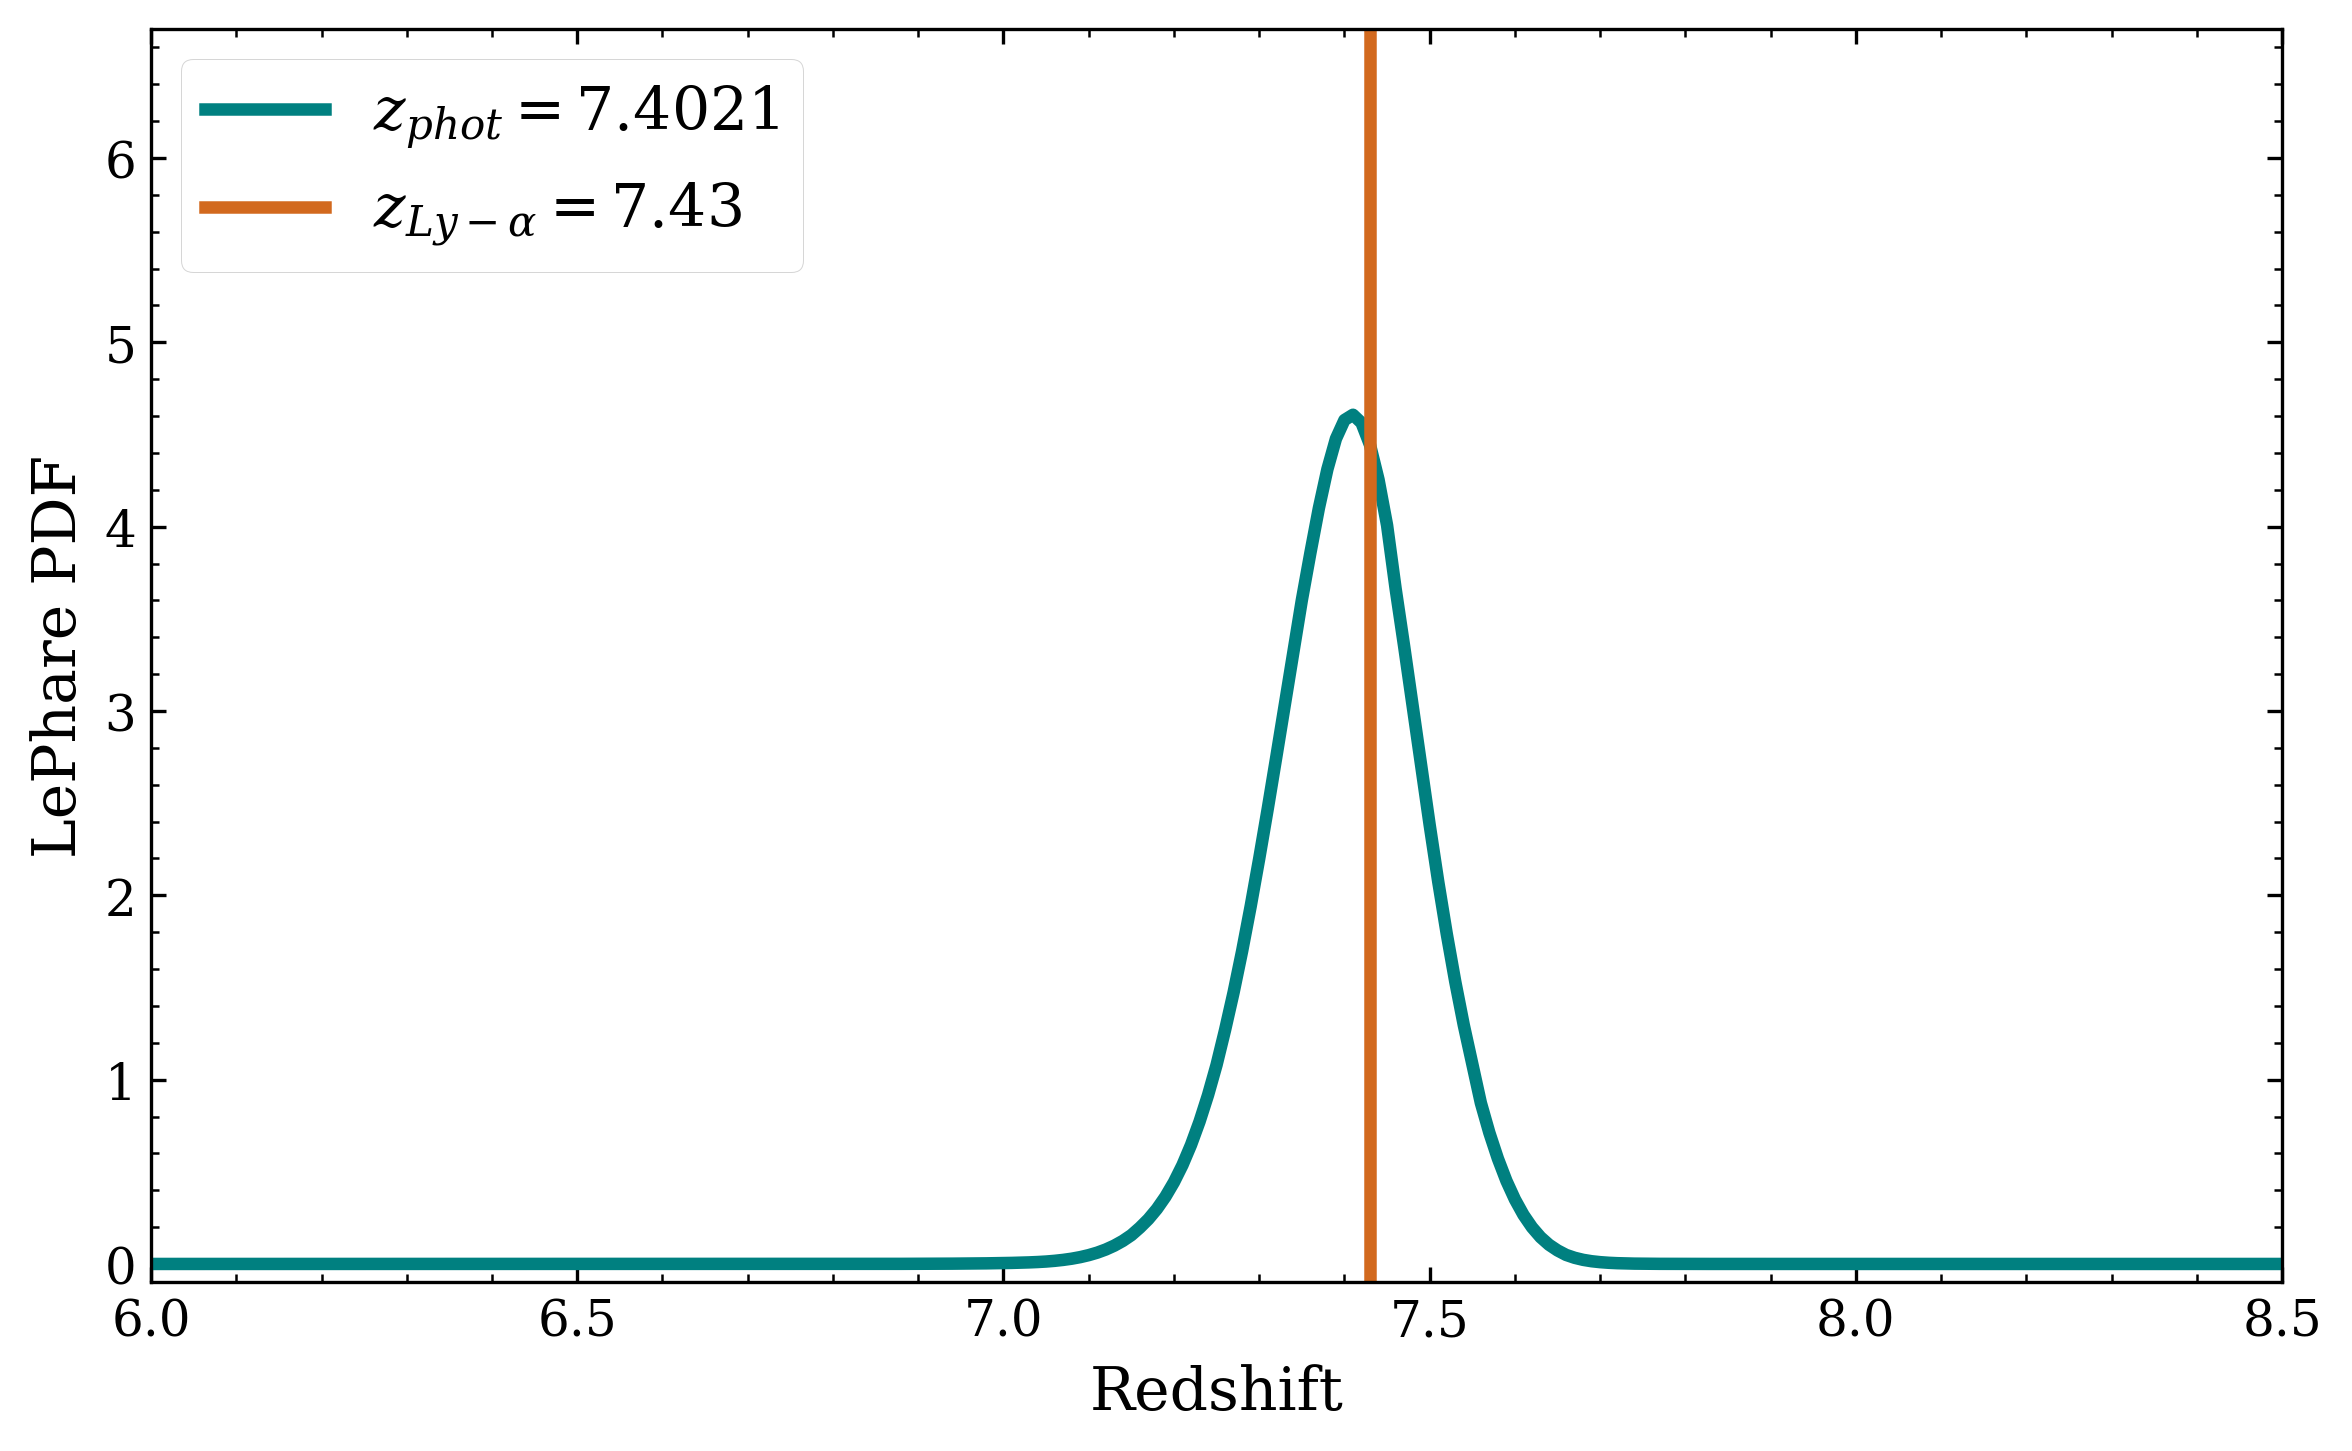

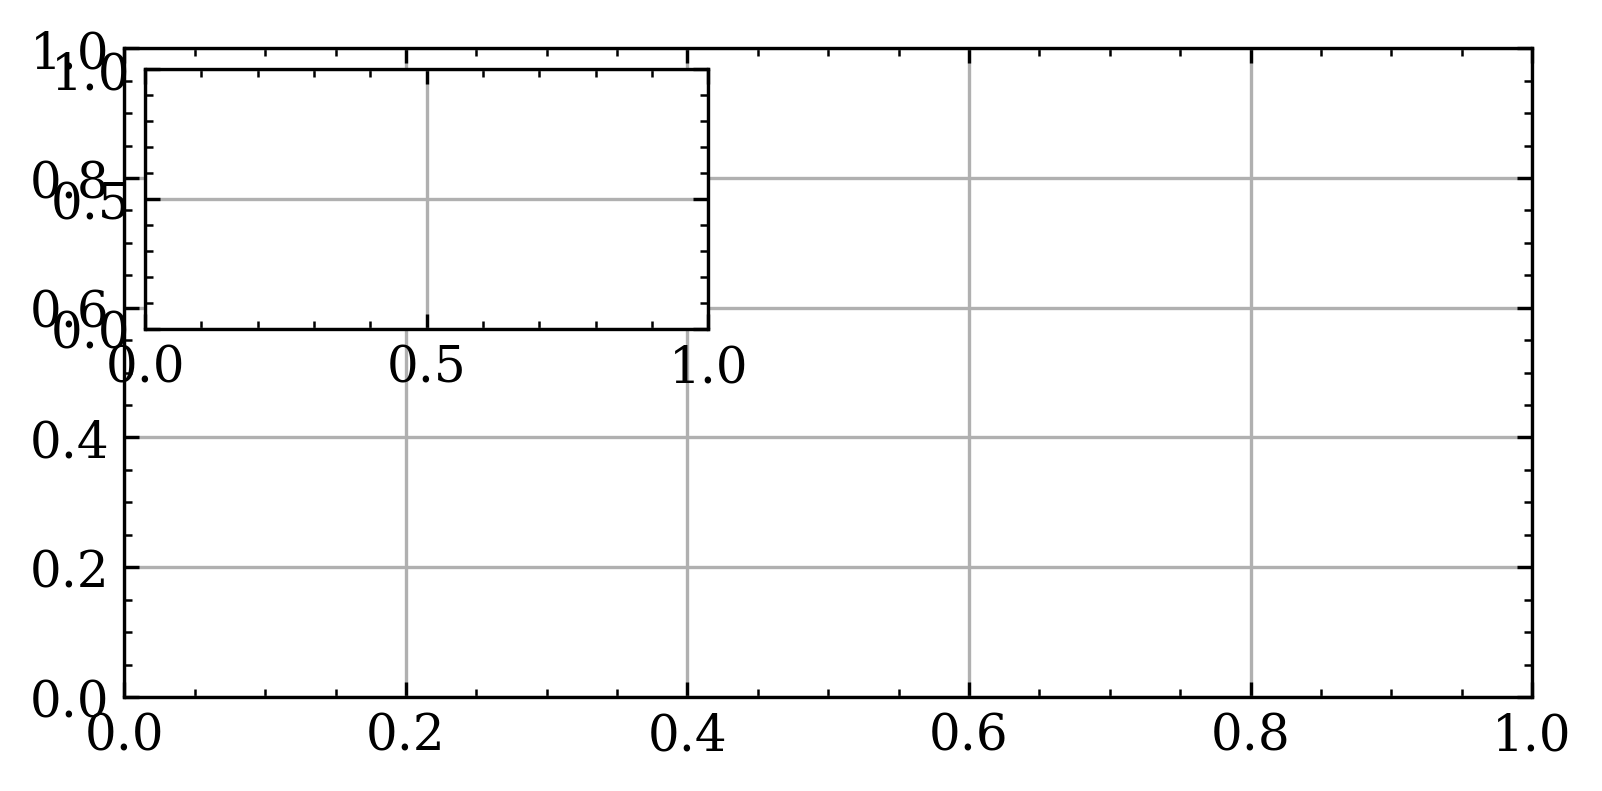

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax = plt.subplots(1, figsize=[5.5, 2.8])

# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins2 = inset_axes(ax, width="40%", height="40%", loc=2)


plt.show()

In [220]:
#image = fits.open('../wmmc01/chimean_wmmc01.fits')
image = fits.open('/Users/oc4858/Library/CloudStorage/Box-Box/treasurechest/uds/hlsp_candels_hst_wfc3_uds-tot_f160w_v1.0_drz.fits')

In [221]:
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip
from astropy.visualization import ZScaleInterval

position = SkyCoord(targ['objra'][0],targ['objdec'][0],unit=(u.deg,u.deg))
wcs = WCS(image[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


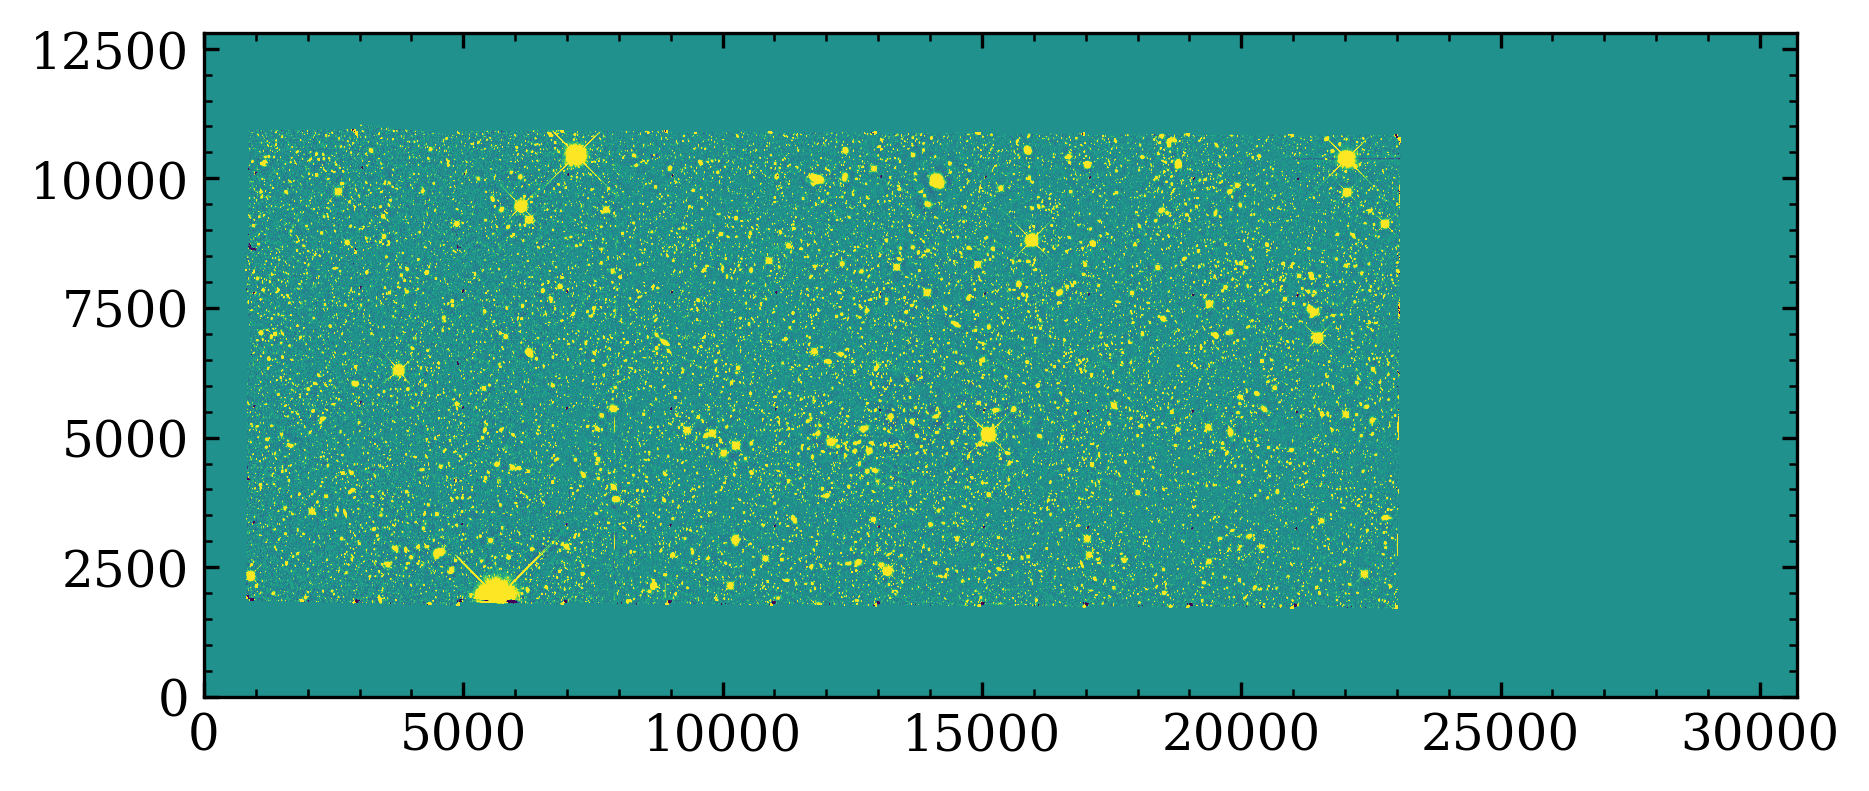

In [227]:
ax = plt.subplot()
ax.grid(False)
interval=ZScaleInterval()
vmin,vmax = interval.get_limits(cutout.data)
ax.imshow(image[0].data, origin='lower', vmin=vmin,vmax=vmax)

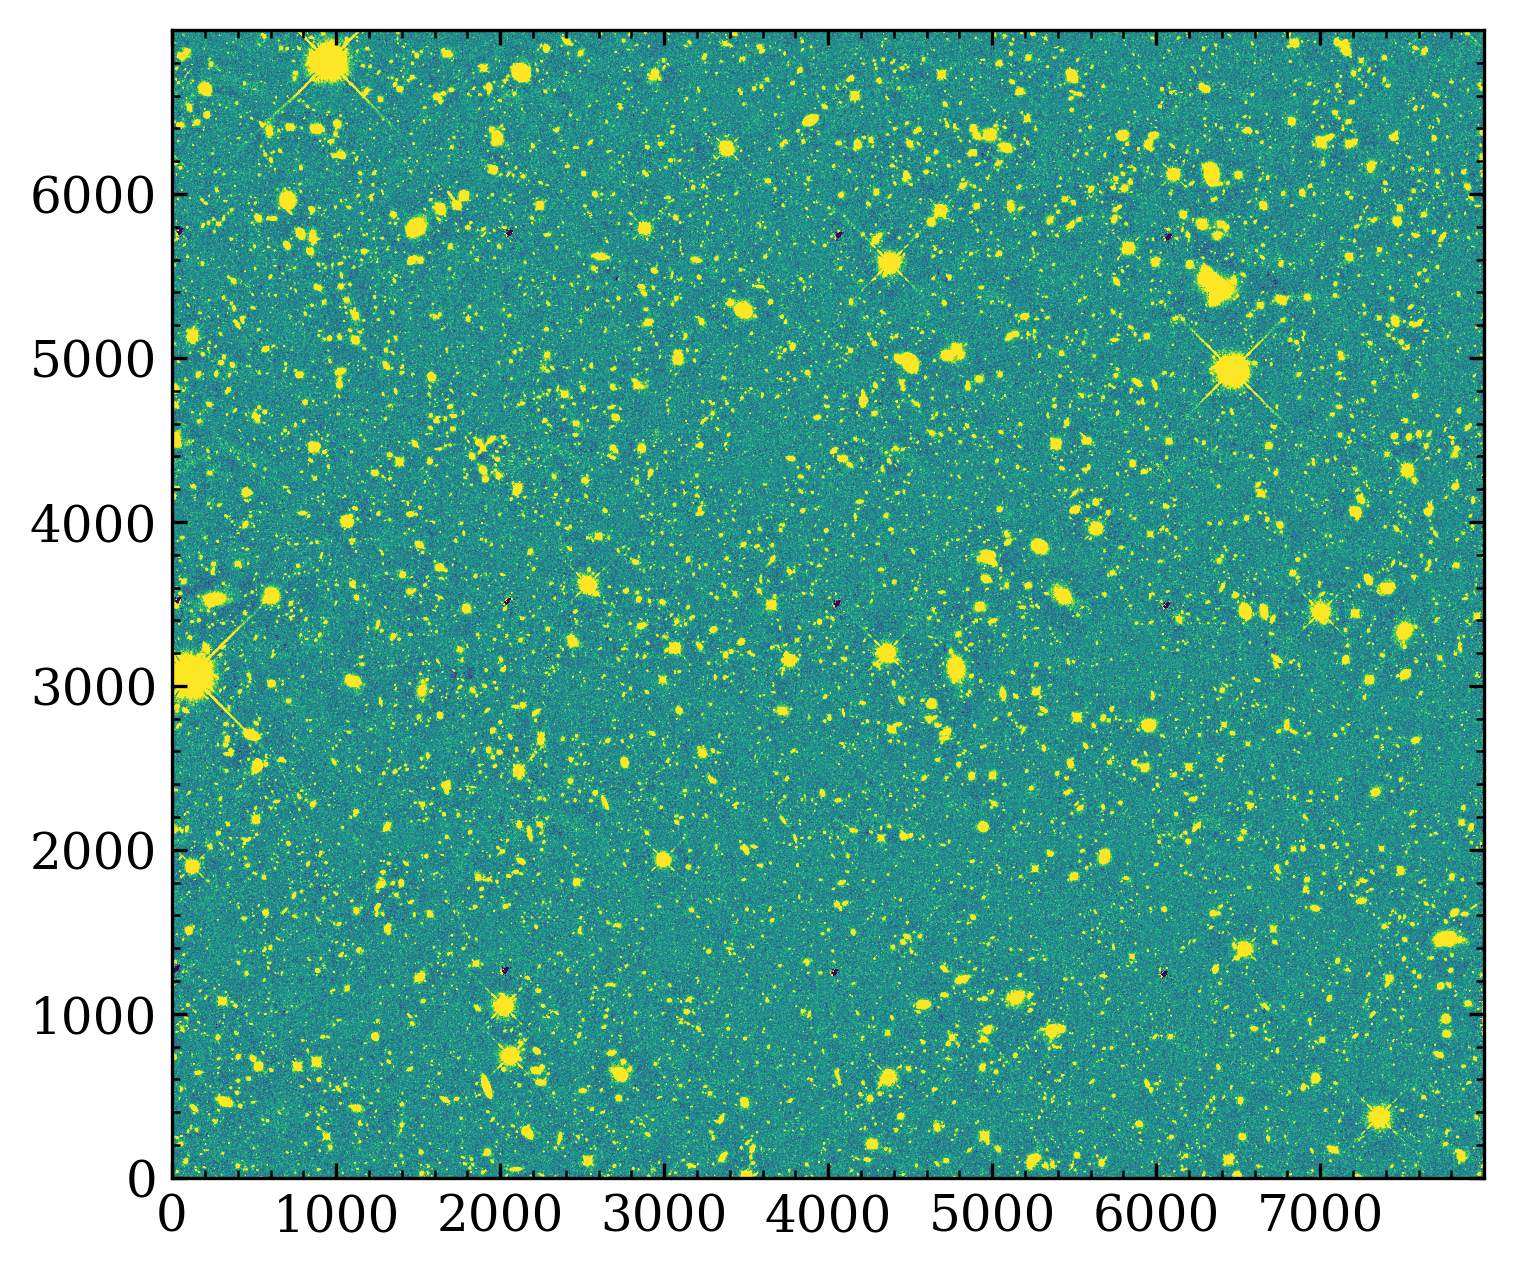

In [232]:
ax = plt.subplot()
ax.grid(False)
interval=ZScaleInterval()
vmin,vmax = interval.get_limits(cutout.data)
ax.imshow(image[0].data[2000:9000,15000:23000], origin='lower', vmin=vmin,vmax=vmax)

In [233]:
outfile = 'werls_uds.fits'

hdu = fits.PrimaryHDU(image[0].data[2000:9000,15000:23000])
hdu.writeto(outfile, overwrite=True)

In [234]:
hdu.writeto?

In [223]:
cutout = Cutout2D(image[0].data, position, size=15*u.arcsec, wcs=wcs)
ax = plt.subplot(projection=wcs)
ax.grid(False)
interval=ZScaleInterval()
vmin,vmax = interval.get_limits(cutout.data)
ax.imshow(cutout.data, origin='lower', vmin=vmin,vmax=vmax)
ax.scatter(150.19379, 2.17021, transform=ax.get_transform('fk5'), s=51, 
           edgecolor='m', facecolor='m',lw=5,zorder=30)
plt.xlabel('RA')
plt.ylabel('Dec')

/opt/anaconda3/lib/python3.9/site-packages/astropy/wcs/wcs.py:1740: RuntimeWarning: All-NaN slice encountered
  while (np.nanmax(dn) >= tol2 and k < maxiter):


NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 1 iterations, the solution is diverging at least for one input point.

In [170]:
ax.scatter(position.ra, position.dec, transform=ax.get_transform('icrs'), s=51, 
           edgecolor='m', facecolor='m',lw=5,zorder=30)

In [151]:
from regions import Regions
regions = Regions.read('../wmmc01/wmmc01_SlitRegions.reg', format='ds9')
Regions.parse(regions, format='ds9')

AttributeError: 'Regions' object has no attribute 'split'

INFO: Auto-setting vmin to -8.453e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.314e-02 [aplpy.core]


/opt/anaconda3/lib/python3.9/site-packages/aplpy/decorators.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  args[0]._figure.canvas.draw()


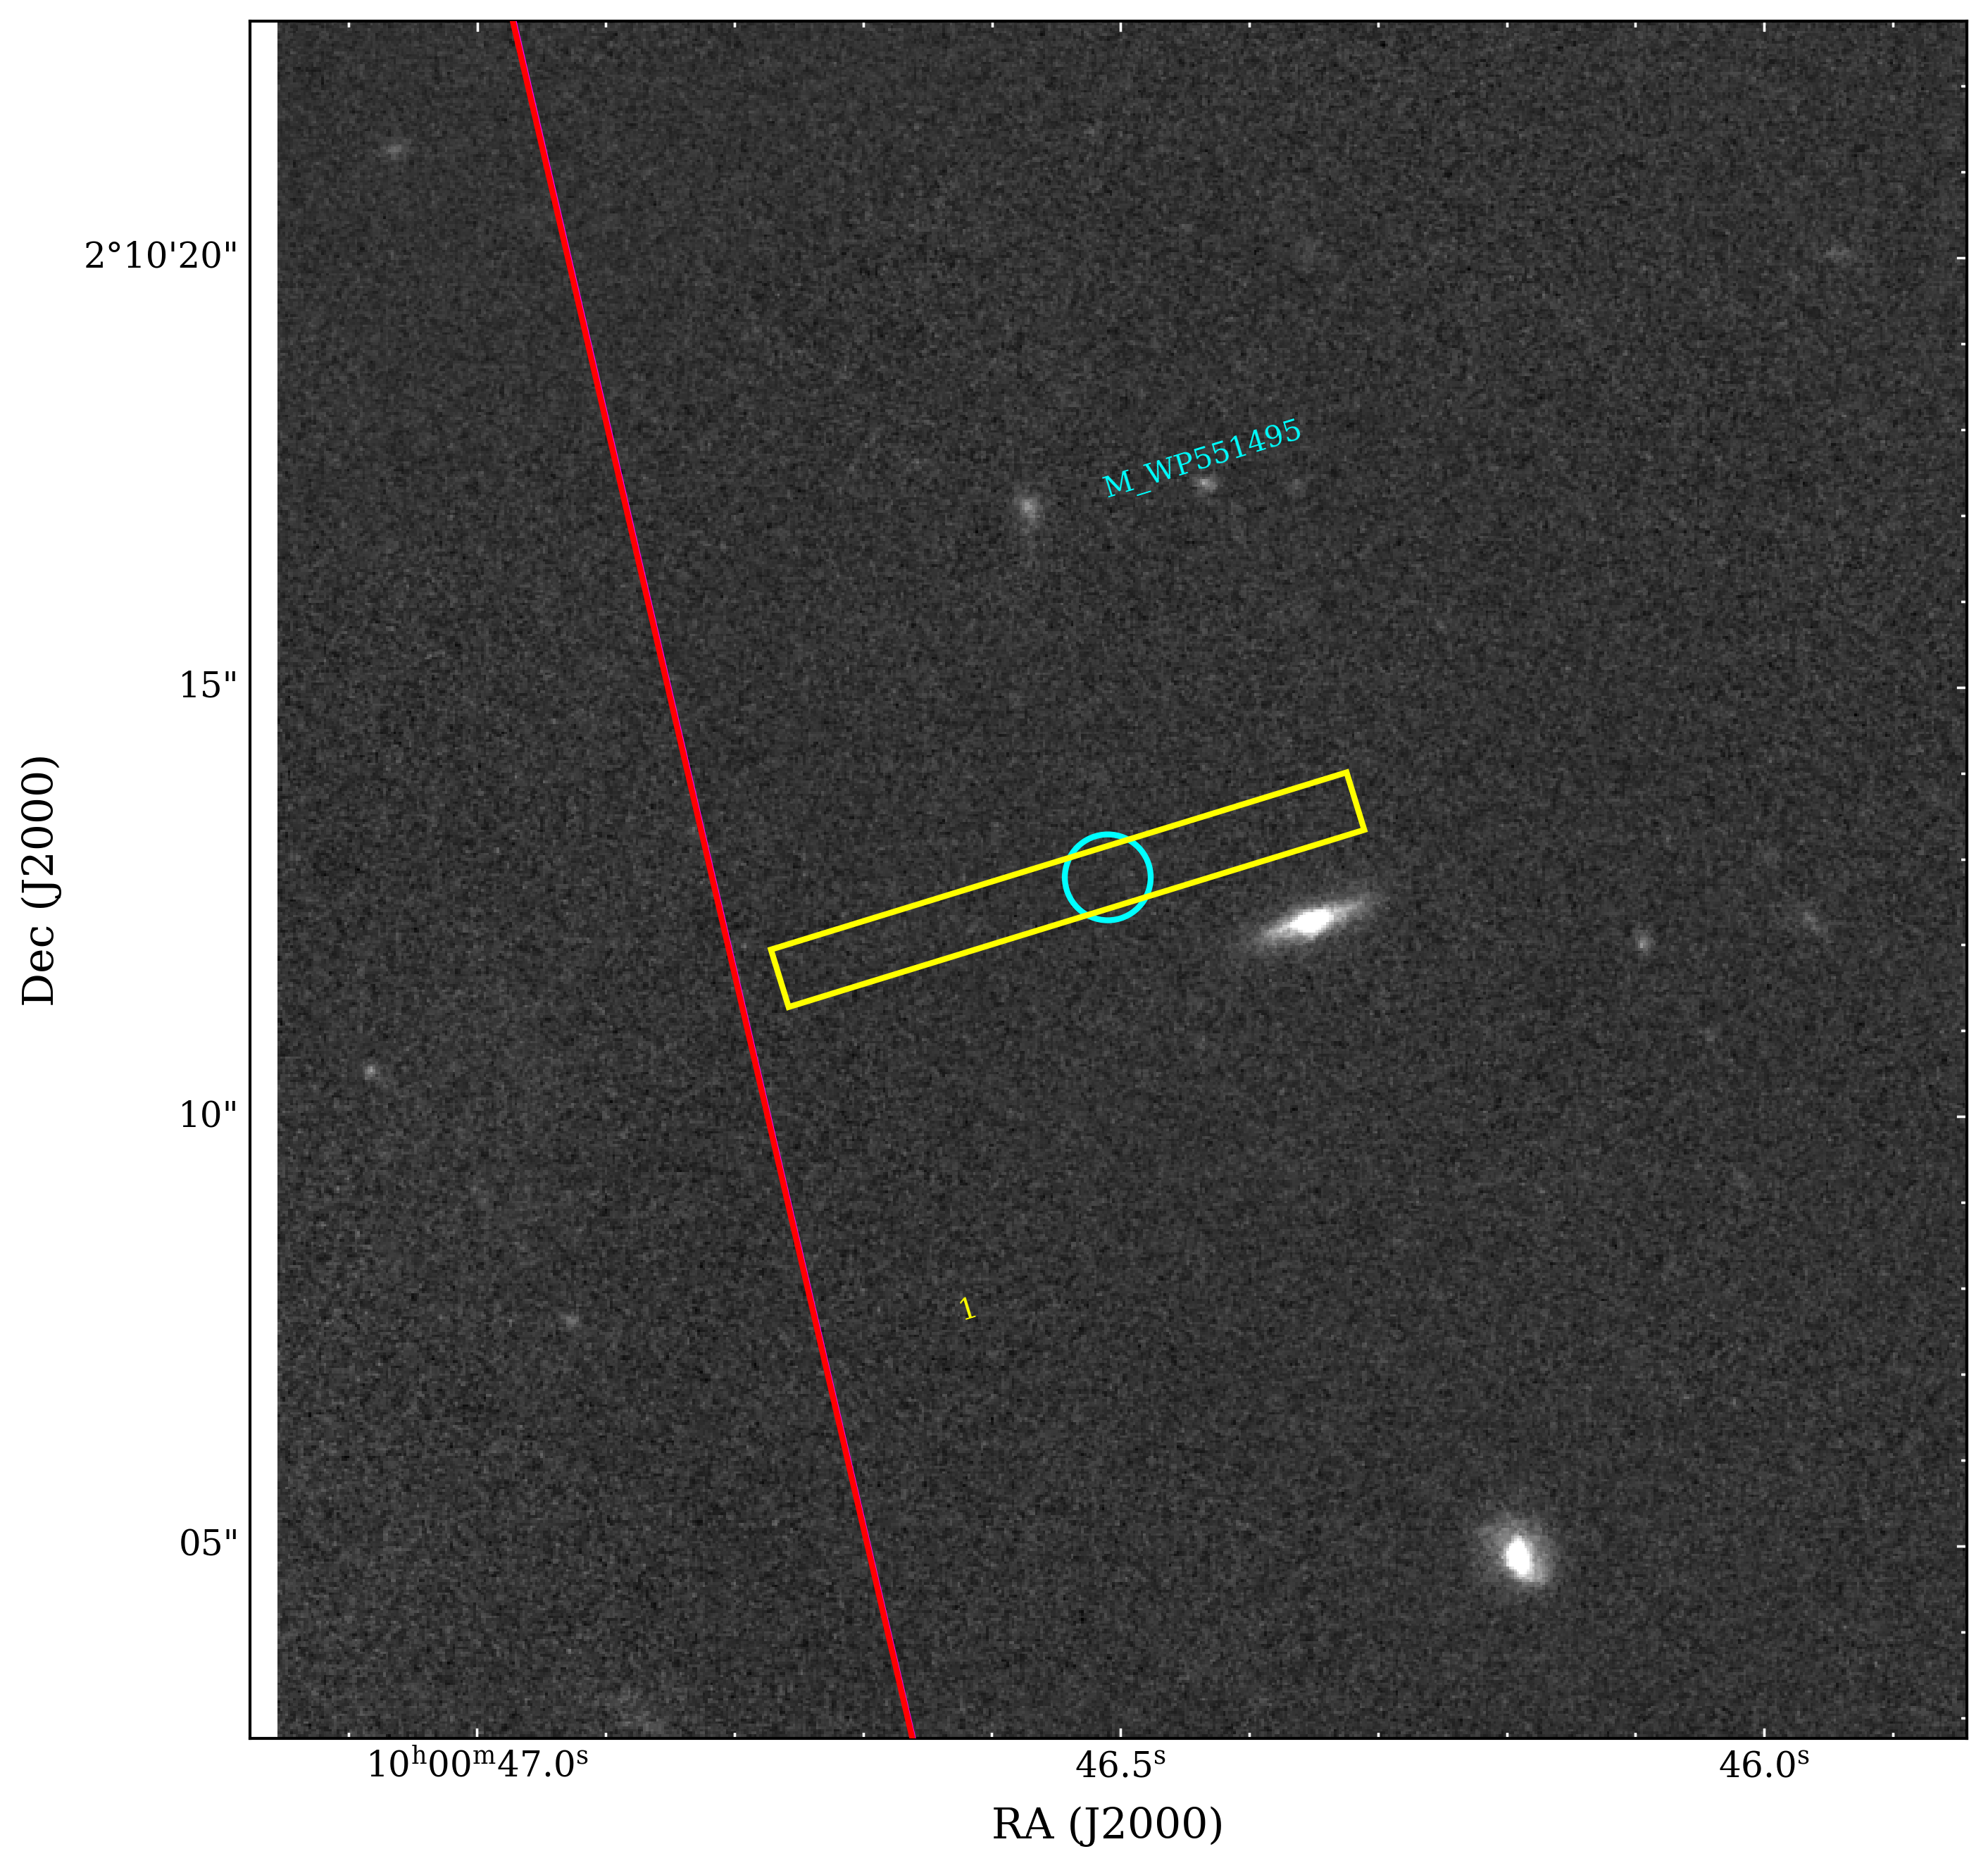

In [261]:
import aplpy

gc = aplpy.FITSFigure('0001_150.14783000_2.19219000_hlsp_candels_hst_acs_cos-tot_f814w_v1.0_drz.fits',north=False)
gc.show_grayscale()
#gc.show_markers(position.ra, position.dec, edgecolor='green', facecolor='g',
     #marker='*', s=100 )
gc.recenter(position.ra, position.dec, radius=10/3600, width=None, height=None)
gc.show_regions('../wmmc01/wmmc01_SlitRegions.reg')
gc.add_grid()
gc.remove_grid()

In [259]:
gc.show_regions?

In [ ]:
gc.show_rgb('graphics/2MASS_arcsinh_color.png')

gc.tick_labels.set_font(size='small')

gc.show_contour('fits/mips_24micron.fits', colors='white')

ra, dec = numpy.loadtxt('data/yso_wcs_only.txt', unpack=True)

gc.show_markers(ra, dec, layer='marker_set_1', edgecolor='red',
                facecolor='none', marker='o', s=10, alpha=0.5)

gc.save('myfirstplot.png')